In [3]:
import numpy as np
from sklearn.datasets import load_iris
import pandas as pd

In [6]:
iris = load_iris(as_frame=True)
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [7]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y =iris["target"].values

In [8]:
X_with_bias = np.c_[np.ones(len(X)),X] # add bias term of one to every element of X

In [9]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size* test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

In [10]:
def to_one_hot(y):
  return np.diag(np.ones(y.max()+1))[y]

In [11]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [12]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [13]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [14]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std


In [15]:
def softmax(logits):
  exps = np.exp(logits)
  exp_sums = exps.sum(axis=1, keepdims=True)
  return exps/exp_sums

In [18]:
n_inputs = X_train.shape[1] # == 3 bc 2 features plus bias 
n_outputs = len(np.unique(y_train)) # == 3 bc 3 iris classes

In [20]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  if epoch % 1000 == 0:
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    print(epoch, xentropy_losses.sum(axis=1).mean())
  error = Y_proba - Y_train_one_hot
  gradients = 1/m * X_train.T @ error
  Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.1451936748083065
2000 0.1301309575504088
3000 0.12009639326384533
4000 0.11372961364786881
5000 0.11002459532472425


In [21]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [22]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In [23]:
# lets add an l2 regularization term
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  if epoch % 1000 == 0:
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1/2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
    print(epoch, total_loss.round(4))
  error = Y_proba - Y_train_one_hot
  gradients = 1/m * X_train.T @ error
  gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
  Theta = Theta - eta*gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


In [24]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In [25]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  Y_proba_valid = softmax(X_valid @ Theta)
  xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
  l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
  total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
  if epoch % 1000 == 0:
      print(epoch, total_loss.round(4))
  if total_loss < best_loss:
      best_loss = total_loss
  else:
      print(epoch - 1, best_loss.round(4))
      print(epoch, total_loss.round(4), "early stopping!")
      break
  error = Y_proba - Y_train_one_hot
  gradients = 1 / m * X_train.T @ error
  gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
  Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [26]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

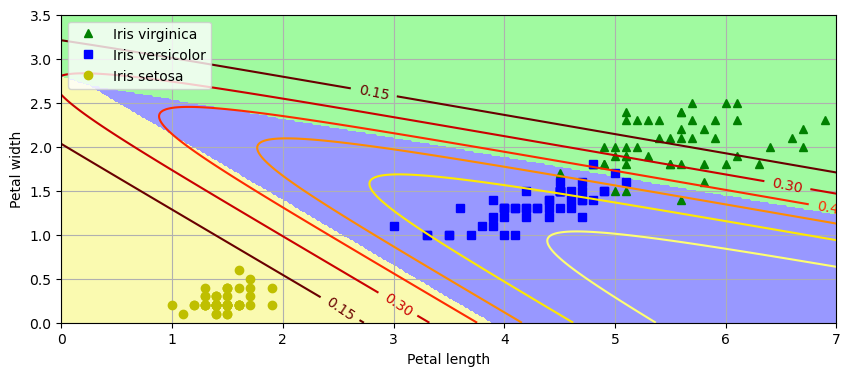

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [30]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667